- Why jump the coordinates from step 0 to step 1 and back from 1 to 2?

## NVE-MD

In [19]:
from profess_calculator import PROFESS
import profess_io as pio
from cpmd import initialize_atoms_old
from ase.md.verlet import VelocityVerlet
from ase import units
import os
import pixiedust
import numpy as np
from matplotlib import pyplot as plt
from ase.io.trajectory import Trajectory
from ase.io.trajectory import TrajectoryReader

In [26]:
# initialize
log = '/home/misa/git_repositories/PROFESS/test/ase_singlepoint/Al4_NVE.log'
traj_path= '/home/misa/git_repositories/PROFESS/test/ase_singlepoint/Al4_NVE.traj'
pos_file = '/home/misa/git_repositories/PROFESS/test/MD_NVE/saved/ion_step0.dat'
vel_file = '/home/misa/git_repositories/PROFESS/test/MD_NVE/saved/vel_step0.dat'
cell_param = [[3.97, 0, 0], [0, 3.97, 0], [0, 0, 3.97]]
atoms = initialize_atoms_old(pos_file, vel_file, cell_param, pos_type='FRAC')

ekin_t0 = atoms.get_kinetic_energy()

# set parameters for PROFESS calculation
run_dir = '/home/misa/git_repositories/PROFESS/test/ase_singlepoint'
inpt_name = 'sp'
pp_names = ['al_HC.lda.recpot']

# make empty calculator
calc = PROFESS()
# pass calculator to atoms object
atoms.calc = calc
# initialize calc object with correct parameters
atoms.calc.initialize(run_dir, inpt_name, pp_names, atoms)

In [27]:
# %%pixie_debugger
# remove old logfile
try:
    os.remove(log)
except FileNotFoundError:
    print('Already deleted')
# atoms.set_calculator(PROFESS(run_dir, inpt_name, pp_names, atoms))
# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(atoms, 1*units.fs, logfile=log)  # 1 fs time step.

traj = Trajectory(traj_path, 'w', dyn.atoms)
dyn.attach(traj.write, interval=10)
dyn.run(100)
traj.close()

In [28]:
read_traj = TrajectoryReader(traj_path)

In [32]:
read_traj[1].get_velocities()

array([[ 0.00059972,  0.06821242, -0.01302725],
       [ 0.03544484, -0.17679931, -0.00235587],
       [ 0.00284043,  0.05931032,  0.1056905 ],
       [-0.03890141,  0.04908388, -0.09037879]])

In [ ]:
print('E_pot(t0) = -231.36188 eV')
print('E_kin(t0) = 1.28567 eV')
print(f'E_tot(t0) = {1.28567 + -231.36188} eV')

print('E_pot(t1) = -231.35305 eV')
print('E_kin(t1) = 1.27680 eV')
print(f'E_tot(t1) = {-231.35305 + 1.27680} eV')

# Compare energies

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from ase import units

import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/apdft-ofdft-cpmd/')
import profess_io as pio

In [5]:
# load reference data
ekin_ref = pio.parse_out_file('/home/misa/git_repositories/PROFESS/test/md_nve_ref/md_nve.out', 'NVE Kinetic energy')
ekin_ref = np.array(ekin_ref)*units.Ha
epot_ref = pio.parse_out_file('/home/misa/git_repositories/PROFESS/test/md_nve_ref/md_nve.out', 'NVE Potential energy')
epot_ref = np.array(epot_ref)*units.Ha
etotal_ref = epot_ref + ekin_ref

e_ase = np.loadtxt('/home/misa/projects/APDFT-CPMD/data/nuclei_md/Al4_NVE_ase_log',skiprows=1)
e_ase_nocopy = np.loadtxt('/home/misa/projects/APDFT-CPMD/data/nuclei_md/Al4_NVE_ase_log_nocopy',skiprows=1)
e_ase_no_dens = np.loadtxt('/home/misa/projects/APDFT-CPMD/data/nuclei_md/Al4_NVE_ase_log_no_dens',skiprows=1)
e_ase_final = np.loadtxt('/home/misa/projects/APDFT-CPMD/data/nuclei_md/Al4_NVE_ase_log_nocopy_new',skiprows=1)

labels = ['ref', r'ase $\rho$ prev step', r'ase $\rho$ from scratch']

# e_ase_1step_MD_ekin = np.loadtxt('/home/misa/projects/APDFT-CPMD/data/nuclei_md/Al4_NVE_ase_ekin_run1step')
# e_ase_1step_MD_etot = np.loadtxt('/home/misa/projects/APDFT-CPMD/data/nuclei_md/Al4_NVE_ase_etot_run1step')

In [9]:
e_ase_final[:,1]

array([-230.0762, -230.0763, -230.0762, ..., -230.0811, -230.0811,
       -230.0812])

In [ ]:
e_ase_nocopy[0]

#### # 1 step MD vs reference

In [ ]:
plt.rcParams['figure.figsize'] = [5,5]
plt.rcParams['font.size'] = 18

fig, ax = plt.subplots(1,1)
for etot,l in zip([etotal_ref, e_ase_1step_MD_etot], ['ref', '1 step']):
    ax.plot(etot, label = l)
ax.legend()
ax.set_xlabel(r'# steps')
ax.set_ylabel(r'$E_{\rm{tot}}$ (eV)')
# plt.savefig('/home/misa/projects/APDFT-CPMD/figures/nuclei_md/one_stepMD.png', bbox_inches='tight')

1 step MD has way stronger drift because error cancelling in velocity verlet algorithm needs information about the previous step

discuss code, name problems

#### E_tot

In [ ]:
plt.rcParams['figure.figsize'] = [5,5]
plt.rcParams['font.size'] = 18.0
fig, ax = plt.subplots(1,1)
for etot,l in zip([etotal_ref, e_ase[:,1], e_ase_no_dens[:,1]], labels):
    ax.plot(etot, label = l)
ax.set_ylabel(r'$E_{\rm{tot}}$ (eV)')
ax.set_xlabel('# steps')
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', borderaxespad=0.0)
ax.set_xlim(-100,2000)
# plt.savefig('/home/misa/projects/APDFT-CPMD/figures/nuclei_md/etot_comparison.png', bbox_inches='tight')

#### E_pot

In [ ]:
plt.rcParams['figure.figsize'] = [5,5]
plt.rcParams['font.size'] = 18.0
fig, ax = plt.subplots(1,1)
for etot,l in zip([epot_ref, e_ase[:,2], e_ase_no_dens[:,2]], labels):
    ax.plot(etot, label = l)
ax.set_ylabel(r'$E_{\rm{pot}}$ (eV)')
ax.set_xlabel('# steps')
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', borderaxespad=0.0)
# plt.savefig('/home/misa/projects/APDFT-CPMD/figures/nuclei_md/epot_comparison.png', bbox_inches='tight')

#### E_kin

In [ ]:
plt.rcParams['figure.figsize'] = [5,5]
plt.rcParams['font.size'] = 18.0
fig, ax = plt.subplots(1,1)
for etot,l in zip([ekin_ref, e_ase[:,3], e_ase_no_dens[:,3]], labels):
    ax.plot(etot, label = l)
ax.set_ylabel(r'$E_{\rm{kin}}$ (eV)')
ax.set_xlabel('# steps')
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', borderaxespad=0.0)
# plt.savefig('/home/misa/projects/APDFT-CPMD/figures/nuclei_md/ekin_comparison.png', bbox_inches='tight')

#### E_tot correct update of atom positions

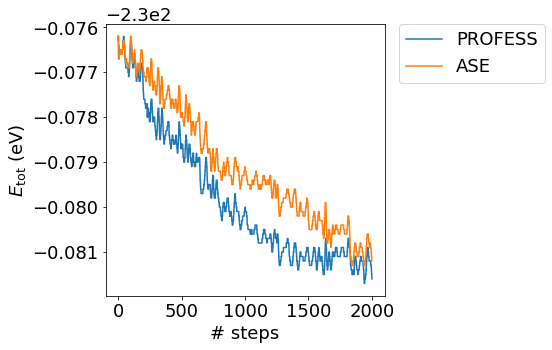

In [10]:
plt.rcParams['figure.figsize'] = [5,5]
plt.rcParams['font.size'] = 18.0
labels = ['ref', r'ase wrong update of positions', r'ase']
fig, ax = plt.subplots(1,1)

ax.plot(np.round(etotal_ref,4), label = "PROFESS")
ax.plot(e_ase_final[:,1], label = "ASE")

ax.set_ylabel(r'$E_{\rm{tot}}$ (eV)')
ax.set_xlabel('# steps')
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', borderaxespad=0.0)
# ax.set_xlim(-5,100)
# ax.set_ylim(-230.078, -230.075)
# plt.savefig('/home/misa/projects/APDFT-CPMD/figures/nuclei_md/etot_update_atoms.png', bbox_inches='tight')

#### multiple plots

In [ ]:
plt.rcParams['figure.figsize'] = [16.5,8]
plt.rcParams['font.size'] = 14.0

import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, 0:1], )
ax2 = plt.subplot(gs[1, 0:1])
ax3 = plt.subplot(gs[1, 2:3])

# fig, ax = plt.subplots(2,2)
for etot,l in zip([etotal_ref, e_ase[:,1], e_ase_no_dens[:,1]], labels):
    ax1.plot(etot, label = l)
    ax1.set_ylabel(r'$E_{\rm{tot}}$ (eV)')
    ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', borderaxespad=0.0)
for ekin,l in zip([ekin_ref, e_ase[:,3], e_ase_no_dens[:,3]], labels):
    ax2.plot(ekin,label = l)
    ax2.set_ylabel(r'$E_{\rm{kin}}$ (eV)')
for epot,l in zip([epot_ref, e_ase[:,2], e_ase_no_dens[:,2]], labels):
    ax3.plot(epot,label = l)
    ax3.set_ylabel(r'$E_{\rm{pot}}$ (eV)')
#     ax[1,0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', borderaxespad=0.0)
    
for i in [ax1, ax2, ax3]:
    i.set_xlabel('# steps')

#### compare positions

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import profess_io as pio
from ase import units

In [ ]:
# monitor change of profess structures

def get_coord_atom(structure_array, num_atom, name_coord):
    coord = []
    for s in structure_array:
        coord.append(s[num_atom][name_coord])
    return(coord)

structure_array = []
for pf in range(1, 21):
    structure_array.append(pio.parse_ion_file(f'/home/misa/git_repositories/PROFESS/test/MD_NVE/saved/ion_step{pf}.dat'))

In [ ]:
num_atom = 3
num_coord = 2
positions_ase = get_coord_atom(save_pos, num_atom, num_coord)
positions_profess = get_coord_atom(structure_array, num_atom, num_coord)
step = np.arange(1, 21)
fig, ax = plt.subplots(1,1)
plt.rcParams['font.size'] = 20
ax.plot(step, positions_ase[:-1], '-o', label = 'ase')
ax.plot(step[1::2], np.array(positions_profess)[1::2]*3.97, '-o', label = 'profess')
# ax.plot(step[1:], np.array(positions_profess)[1:]*3.97, '-o', label = 'profess')


ax.set_xlabel(r'step $n$')
ax.set_ylabel(r'$R_{I, i}$ (Ang)')
ax.legend()

#### compare velocities

In [ ]:
# velocities from Bohr/aut (PROFESS) -> Ang/ (Ang sqrt(aum/eV)) (ASE)
# Bohr -> Ang = length_in_Bohr*units.Bohr
# aut -> Ang sqrt(aum/eV)
aut2fs = 2.41888433e-2 # go from aut -> fs
aut2aset = aut2fs*units.fs # from aut -> aset (ase time unit)
au_vel2ase_vel = units.Bohr/aut2aset # conversion of velocities in a.u. to native ase units

# get velocities from profess
vel_array = []
for pf in range(1, 21):
    vel_array.append(pio.parse_velocity_file(f'/home/misa/git_repositories/PROFESS/test/MD_NVE/saved/vel_step{pf}.dat'))

num_atom = 0
num_coord = 0
velocities_ase = get_coord_atom(np.array(save_vel)/au_vel2ase_vel, num_atom, num_coord)
velocities_profess = get_coord_atom(vel_array, num_atom, num_coord)

step = np.arange(1, 21)

plt.rcParams['font.size'] = 15
fig, ax = plt.subplots(1,1)

ax.plot(step, velocities_ase[:-1], '-o', label = 'ase')
ax.plot(step, velocities_profess, '-o', label = 'profess')

ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax.set_xlabel(r'step $n$')
ax.set_ylabel(r'$v_{I,i}$ (a.u.)')
ax.legend()

files for ofdft:
- job.inpt (stays the same during CPMD)
- job.ion (structure: update position, lattice vectors?)
- density (update from CPMD)
- al.lda.recpot (pseudopotentials: stay the same during CPMD)

Which code to do APDFT calculations? (must support crystal structures)
Are local ofdft pseudopotentials compatible with other non-local pseudopotentials?

How to do MD runs in OFDFT for comparison?

How to run NVE, What is NVT coupled with Nose-Hoover?
Why are the positions negative, so close togethcer and different from initial structure?



- get forces, velocities from ofdft during python runtime
- propagate nuclei


            